<a href="https://colab.research.google.com/github/PravyPrerana-1610/Codes/blob/main/EE_von_Neumann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# comments to be added

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


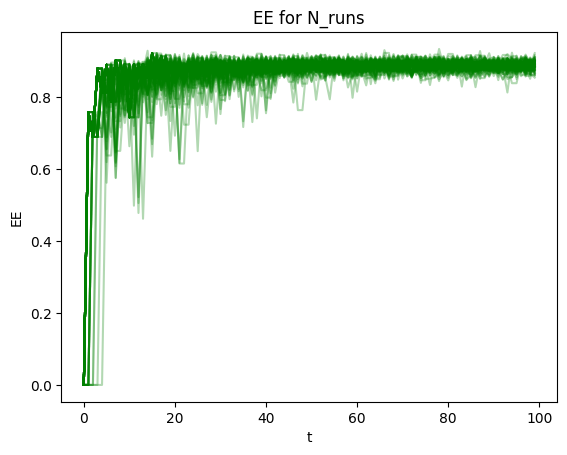

In [1]:

import networkx as nx
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

#%% Graph setup
N_nodes = 100
m = 2
G = nx.barabasi_albert_graph(N_nodes, m).to_directed()
#nx.draw(G, with_labels=True)

#%% Grover coin
def grover(d):
    return 2/d * np.ones((d, d)) - np.identity(d)

def grovercoin(G):
    """Big Grover coin for all nodes"""
    big_coin = grover(G.out_degree(0))
    for j in list(G.nodes)[1:]:
        big_coin = block_diag(big_coin, grover(G.out_degree(j)))
    return big_coin

#%% Flip-flop shift operator
def FF(G):
    flipflop = np.zeros((len(G.edges), len(G.edges)))
    arcs = np.array(G.edges)
    for j in G.nodes:
        connections = np.where(arcs[:, 0] == j)
        for i in arcs[connections[0]][:, 1]:
            id0 = ((arcs == (i, j)).all(axis=1).nonzero())[0][0]
            id1 = ((arcs == (j, i)).all(axis=1).nonzero())[0][0]
            flipflop[id0, id1] = 1
    return flipflop

#%% Tumble operator
def tumble(state, G):
    degrees = np.array(G.out_degree)
    new_state = np.zeros(len(G.edges), dtype=complex)
    for x in G.nodes:
        start = np.sum(degrees[:x, 1])
        end = np.sum(degrees[:x+1, 1])
        new_state[start:end] = np.random.permutation(state[start:end])
    return new_state

#%% Von Neumann entropy (NumPy version)
def von_neumann_entropy_probs(state, degrees, num_nodes, tol=1e-12):
    probs = np.zeros(num_nodes)
    for i in range(num_nodes):
        start = np.sum(degrees[:i, 1])
        end = np.sum(degrees[:i+1, 1])
        vec = state[start:end]
        probs[i] = np.vdot(vec, vec).real  # |amplitudes|^2 summed

    probs = probs[probs > tol]  # remove tiny numerical noise
    return -np.sum(probs * np.log2(probs))

#%% Initialize
dim = len(G.edges)
degrees = np.array(G.out_degree)
S = FF(G)
U = S @ grovercoin(G)

init_state = np.zeros(dim, dtype=complex)
init_state[0:G.out_degree(0)] = np.ones(G.out_degree(0)) / np.sqrt(G.out_degree(0))

#%% Evolution function
t = 100
p_tumble = 0.1

def evolution(init_state):
    state = init_state.copy()
    occupation = np.zeros((len(G.nodes), t))
    EE_values = np.zeros(t)

    for j in range(t):
        # Node occupations
        for x in G.nodes:
            start = np.sum(degrees[:x, 1])
            end = np.sum(degrees[:x+1, 1])
            occupation[x, j] = np.vdot(state[start:end], state[start:end]).real

        # Von Neumann entropy
        EE_values[j] = von_neumann_entropy_probs(state, degrees, len(G.nodes))

        # Evolve state
        if np.random.rand() < p_tumble:
            state = tumble(state, G)
        else:
            state = U @ state

    return occupation, EE_values

#%% Run simulations in parallel
N_runs = 100
results = Parallel(n_jobs=-1)(delayed(evolution)(init_state) for _ in tqdm(range(N_runs)))
EE_runs_coin = np.array([res[1] for res in results])
EE_runs_coin=EE_runs_coin/np.log2(len(G.nodes))

#%% Plot EE
for k in range(N_runs):
    plt.plot(EE_runs_coin[k], alpha=0.3, color='green')
plt.xlabel("t")
plt.ylabel("EE")
plt.title("EE for N_runs")
plt.show()